<a href="https://colab.research.google.com/github/alexndremelyanov/_/blob/main/L5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

data = pd.read_csv('video_games.csv')
data.head()

,id,platform,year,genre,publisher,na_sales,eu_sales,other_sales,jp_sales
0,2830,PSV,2012,Racing,Electronic Arts,0.38,0.52,0.25,1.01
1,3865,SNES,1996,Role-Playing,ASCII Entertainment,0.00,0.00,0.00,1.31
2,4617,PSP,2009,Sports,Takara Tomy,0.09,0.00,0.01,1.04
3,3675,DS,2007,Fighting,Takara Tomy,0.00,0.00,0.00,1.08
4,1612,PSV,2016,Action,Namco Bandai Games,0.00,0.00,0.00,1.12


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4258 entries, 0 to 4257
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           4258 non-null   int64  
 1   platform     4258 non-null   object 
 2   year         4258 non-null   int64  
 3   genre        4258 non-null   object 
 4   publisher    4258 non-null   object 
 5   na_sales     4258 non-null   float64
 6   eu_sales     4258 non-null   float64
 7   other_sales  4258 non-null   float64
 8   jp_sales     4258 non-null   float64
dtypes: float64(4), int64(2), object(3)
memory usage: 299.5+ KB


In [3]:
numeric_features = ['na_sales','eu_sales','other_sales']
categorical_features = ['year','platform' , 'genre','publisher']

In [4]:
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(data[categorical_features])
x = np.hstack((data[numeric_features].values, encoded_features))

In [5]:
y = data["jp_sales"]

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
class LinearRegressionGD:
    def __init__(self, lr=0.01, max_iter=1000, tol=1e-3, intercept = True):
        # скорость обучения градиентного спуска
        self.learning_rate = lr
        # максимальное число итераций
        self.max_iteration = max_iter
        # критерий сходимости
        self.tolerance_convergence  = tol
        # наличие свободного члена
        self.intercept = intercept
        # инициальзация весов: None
        self.theta = None
        self.n = None
        self.d = None

    def fit(self, X, y, x_, y_):
        self.X = X.copy()
        if self.intercept:
            self.X = np.hstack((np.ones((self.X.shape[0], 1)), self.X))
        # размерность вектора X
        self.n, self.d = self.X.shape
        # инициализация случайных весов
        self.theta = np.random.randn(self.d)
        steps, errors, errors_ = [], [], []
        step = 0
        for _ in range(self.max_iteration):
            grad = self.gradient(self.X, y)
            self.theta -= self.learning_rate * grad
            new_error = ((y - self.predict(X)).T @ (y - self.predict(X))) / self.n
            new_error_ = self.MSE(x_, y_)
            step += 1
            steps.append(step)
            errors.append(new_error)
            errors_.append(new_error_)
            # проверка сходимости
            if np.linalg.norm(grad) < self.tolerance_convergence:
                break
        return steps, errors, errors_

    def gradient(self, X, y):
        return X.T @ (X @ self.theta - y) / len(y)

    def predict(self, X):
        if self.intercept:
            X_ = np.hstack((np.ones((X.shape[0],1)), X))
        else:
            X_ = X
        return X_ @ self.theta

    def MSE(self, X, y):
        return ((y - self.predict(X)).T @ (y - self.predict(X))) / len(y)

    def MAE(self, X, y):
        return abs(y - self.predict(X)).mean()

    def MAPE(self, X, y):
        return abs((y - self.predict(X))/y).mean()

Время обучения: 15.778180122375488
MSE_train:  1.2248868179504906
MSE_test:  1.3098715137059669


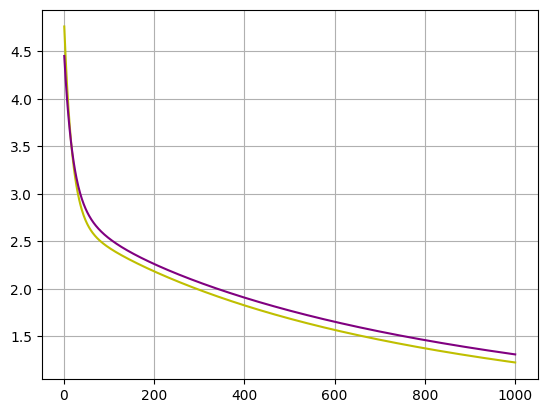

In [8]:
start_time = time.time()
modelGD = LinearRegressionGD(lr=0.01, max_iter=1000, tol=1e-3)
stepsGD1, errorsGD1, errorsGD2 = modelGD.fit(x_train, y_train, x_test, y_test)
timeGD = time.time() - start_time
print("Время обучения:", timeGD)
MSE_GD_train = modelGD.MSE(x_train, y_train)
MSE_GD_test = modelGD.MSE(x_test, y_test)
print("MSE_train: ", MSE_GD_train)
print("MSE_test: ", MSE_GD_test)

plt.plot(stepsGD1, errorsGD1, label = "MSE train", color='y')
plt.plot(stepsGD1, errorsGD2, label = "MSE test", color='purple')
plt.grid()


In [9]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [10]:
class LinearRegressionSGD:
    def __init__(self, lr=0.01, max_iter=1000, batch_size=32, tol=1e-3, intercept = True):
        # скорость обучения градиентного спуска
        self.learning_rate = lr
        # максимальное число итераций
        self.max_iteration = max_iter
        # размер мини-батча
        self.batch_size = batch_size
        # критерий сходимости
        self.tolerance_convergence  = tol
        # наличие свободного члена
        self.intercept = intercept
        # инициальзация весов: None
        self.theta = None
        self.n = None
        self.d = None

    def fit(self, X, y, x_, y_):
        self.X = X.copy()
        self.y = y.copy()
        if self.intercept:
            self.X = np.hstack((np.ones((self.X.shape[0], 1)), self.X))
        # размерность вектора X
        self.n, self.d = self.X.shape
        # инициализация случайных весов
        self.theta = np.random.randn(self.d)
        steps, errors, errors_ = [], [], []
        step = 0
        for _ in range(self.max_iteration):
            # перемешивание данных
            indices = np.random.permutation(self.n)
            X = self.X[indices]
            y = self.y[indices]
            # цикл по мини-батчам
            for i in range(0, self.n, self.batch_size):
                X_batch = X[i:i+self.batch_size]
                y_batch = y[i:i+self.batch_size]
                grad = self.gradient(X_batch, y_batch)
                self.theta -= self.learning_rate * grad
            new_error = ((self.y - self.X @ self.theta).T @ (self.y - self.X @ self.theta)) / self.n
            new_error_ = self.MSE(x_, y_)
            step += 1
            steps.append(step)
            errors.append(new_error)
            errors_.append(new_error_)
            # проверка сходимости
            if np.linalg.norm(grad) < self.tolerance_convergence:
                break
        return steps, errors, errors_

    def gradient(self, X, y):
        return X.T @ (X @ self.theta - y) / len(y)

    def predict(self, X):
        if self.intercept:
            X_ = np.hstack((np.ones((X.shape[0],1)), X))
        else:
            X_ = X
        return X_ @ self.theta

    def MSE(self, X, y):
        return ((y - self.predict(X)).T @ (y - self.predict(X))) / len(y)

    def MAE(self, X, y):
        return abs(y - self.predict(X)).mean()

    def MAPE(self, X, y):
        return abs((y - self.predict(X))/y).mean()

Время обучения: 45.074751138687134
MSE_train:  0.18359889819305306
MSE_test:  0.23892484001481928


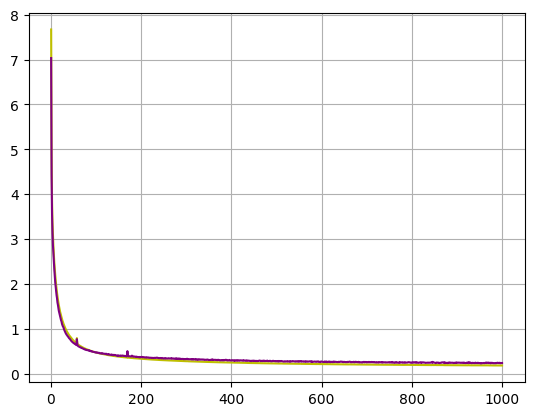

In [11]:
start_time = time.time()
modelSGD = LinearRegressionSGD(lr=0.01, max_iter=1000, batch_size=64, tol=1e-3, intercept = True)
stepsSGD1, errorsSGD1, errorsSGD2 = modelSGD.fit(x_train, y_train, x_test, y_test)
timeSGD = time.time() - start_time
print("Время обучения:", timeSGD)
MSE_SGD_train = modelSGD.MSE(x_train, y_train)
MSE_SGD_test = modelSGD.MSE(x_test, y_test)
print("MSE_train: ", MSE_SGD_train)
print("MSE_test: ", MSE_SGD_test)

plt.plot(stepsSGD1, errorsSGD1, label = "MSE train", color='y')
plt.plot(stepsSGD1, errorsSGD2, label = "MSE test", color='purple')
plt.grid()

In [12]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [13]:
class ADAM:
  def __init__(self, lr=0.01, max_iter=100, tol=1e-3, intercept = True, beta1=0.9, beta2=0.999, epsylon = 1e-8):
    self.learning_rate = lr
    self.max_iteration = max_iter
    self.tolerance_convergence  = tol
    self.intercept = intercept
    self.theta = None
    self.n = None
    self.d = None
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsylon = epsylon
    self.s = None
    self.v = None

  def fit(self, X, y, x_, y_):
        self.X = X.copy()
        if self.intercept:
            self.X = np.hstack((np.ones((self.X.shape[0], 1)), self.X))
        self.n, self.d = self.X.shape
        self.theta = np.random.randn(self.d)
        self.s = np.zeros(self.d)
        self.v = np.zeros(self.d)
        steps, errors, errors_ = [], [], []
        step = 0
        for _ in range(self.max_iteration):
            grad = self.gradient(self.X, y)
            self.s = self.beta1*self.s + (1 - self.beta1)*grad
            self.v = self.beta2*self.v + (1-self.beta2)*(grad**2)
            s_hat = self.s / (1-self.beta1**(_ + 1))
            v_hat = self.v / (1-self.beta2**(_ + 1))
            self.theta -= self.learning_rate * s_hat / (np.sqrt(v_hat) + self.epsylon)
            new_error = ((y - self.predict(X)).T @ (y - self.predict(X))) / self.n
            new_error_ = self.MSE(x_, y_)
            step += 1
            steps.append(step)
            errors.append(new_error)
            errors_.append(new_error_)
            if np.linalg.norm(grad) < self.tolerance_convergence:
                break
        return steps, errors, errors_


  def gradient(self, X, y):
       return X.T @ (X @ self.theta - y) / len(y)

  def predict(self, X):
      if self.intercept:
          X_ = np.hstack((np.ones((X.shape[0],1)), X))
      else:
           X_ = X
      return X_ @ self.theta

  def MSE(self, X, y):
      return ((y - self.predict(X)).T @ (y - self.predict(X))) / len(y)

Время обучения: 17.315126180648804
MSE_train:  0.12274538960276045
MSE_test:  0.17592718052036516


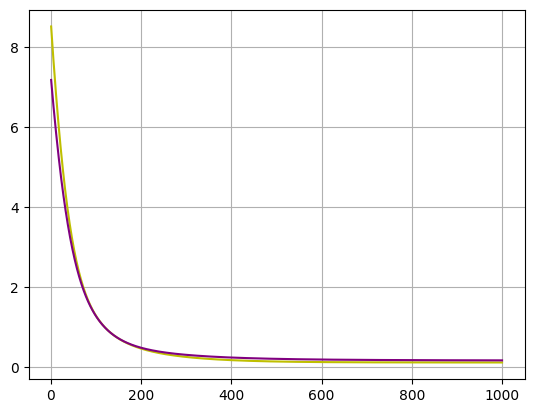

In [14]:
start_time = time.time()
modelADAM = ADAM(lr=0.01, max_iter=1000, tol=1e-3, intercept = True, beta1=0.9, beta2=0.999, epsylon = 1e-8)
stepsADAM1, errorsADAM1, errorsADAM2 = modelADAM.fit(x_train, y_train, x_test, y_test)
timeA = time.time() - start_time
print("Время обучения:", timeA)
MSE_A_train = modelADAM.MSE(x_train, y_train)
MSE_A_test = modelADAM.MSE(x_test, y_test)
print("MSE_train: ", MSE_A_train)
print("MSE_test: ", MSE_A_test)

plt.plot(stepsADAM1, errorsADAM1, label = 'MSE train', color='y')
plt.plot(stepsADAM1, errorsADAM2, label = 'MSE test', color='purple')
plt.grid()



In [15]:
result = pd.DataFrame(columns=['Метод','MSE train','MSE test', 'Время'])
result.loc[0] = ['GD', MSE_GD_train, MSE_GD_test, timeGD]
result.loc[1] = ['SGD', MSE_SGD_train, MSE_SGD_test, timeSGD]
result.loc[2] = ['Adam', MSE_A_train, MSE_A_test, timeA]
result

,Метод,MSE train,MSE test,Время
0,GD,1.224887,1.309872,15.778180
1,SGD,0.183599,0.238925,45.074751
2,Adam,0.122745,0.175927,17.315126


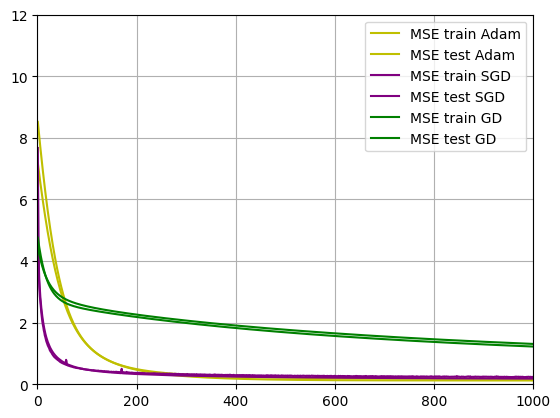

In [16]:
plt.plot(stepsADAM1, errorsADAM1, label = 'MSE train Adam', color='y')
plt.plot(stepsADAM1, errorsADAM2, label = 'MSE test Adam', color='y')

plt.plot(stepsSGD1, errorsSGD1, label = 'MSE train SGD', color='purple')
plt.plot(stepsSGD1, errorsSGD2, label = 'MSE test SGD', color='purple')

plt.plot(stepsGD1, errorsGD1, label = 'MSE train GD', color='green')
plt.plot(stepsGD1, errorsGD2, label = 'MSE test GD', color='green')

plt.grid()
plt.ylim(0,12)
plt.xlim(0,1000)
plt.legend()